In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class BanditGaussian:
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
    self.Q_t = 0
    self.t = 0

  def pull(self):
    return np.random.normal(loc=self.mean, scale=self.std)

  def update(self, curr_reward):
    self.t += 1
    self.Q_t = self.Q_t + (1.0/self.t) * (curr_reward - self.Q_t)

In [ ]:
def epsilon_greedy_policy(bandits, epsilon=0):
  Q_values = [b.Q_t for b in bandits]

  choice = np.random.rand()
  if choice > epsilon:
    index = np.argmax(Q_values)
  else:
    index = np.random.choice(len(bandits), 1)[0]
    
  bandit = bandits[index]
  return bandit, index

In [ ]:
def interact_with_bandit(bandit):
  reward = bandit.pull()
  bandit.update(reward)

  return reward

In [ ]:
def simple_exploration(bandits, num_explorations):
  for b in bandits:
    for n in range(num_explorations):
      interact_with_bandit(b)

In [ ]:
def run_bandits_experiment(bandits_array, num_iterations, epsilon, num_explorations):
  rewards_array = np.empty(num_iterations)
  indexes_array = np.empty(num_iterations)

  if num_explorations > 0:
    simple_exploration(bandits_array, num_explorations)

  for n in np.arange(num_iterations):
    bandit, index = epsilon_greedy_policy(bandits_array, epsilon)
    curr_reward = interact_with_bandit(bandit)
    rewards_array[n] = curr_reward
    indexes_array[n] = index

  return rewards_array, indexes_array

In [ ]:
def get_mean_cumulative_reward(reward_array):
  cumulative_reward = np.cumsum(reward_array)
  mean_cumulative_reward = cumulative_reward / (np.arange(len(reward_array)) + 1)
  return mean_cumulative_reward

In [ ]:
def main(epsilons, num_iterations=100, num_explorations=0, n_runs=1):
  mean_array = [10, 11, 12, 13, 14]
  mean_cumulative_rewards = np.empty((len(epsilons), num_iterations))
  interactions = np.empty((len(epsilons), num_iterations*n_runs))

  for i, epsilon in enumerate(epsilons):
    rewards_array = np.zeros(num_iterations)
    inters = []

    for run in range(n_runs):
      bandits_array = list(map(lambda mean: BanditGaussian(mean, 1), mean_array))
      arr, inter = run_bandits_experiment(bandits_array, num_iterations, epsilon, num_explorations=num_explorations)
      rewards_array += arr
      inters = np.concatenate((inters, inter))
      
    mean_cumulative_rewards[i] = get_mean_cumulative_reward(rewards_array/n_runs)
    interactions[i] = inters

  return {
      'bandits': bandits_array, 
      'rewards': mean_cumulative_rewards,
      'epsilons': epsilons,
      'num_iterations': num_iterations,
      'interactions': interactions,
      'n_runs': n_runs}

In [ ]:
def plot_rewards(run, ax,
                 title='',
                 xlabel='',
                 ylabel=''):
  bandits_array = run['bandits']
  mean_cumulative_rewards = run['rewards']
  epsilons = run['epsilons']
  num_iterations = run['num_iterations']

  legends = []
  for epsilon, mean_cumulative_reward in zip(epsilons, mean_cumulative_rewards):
    ax.plot(mean_cumulative_reward)
    legends.append(f'ϵ - {epsilon}')
  for cont, b in enumerate(bandits_array):
    ax.plot(np.ones(num_iterations) * b.mean)
    legends.append('bandido ' + str(cont))
  
  ax.set_xscale('log')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.legend(legends)

In [ ]:
def plot_interactions(run, ax,
                      title='',
                      xlabel='',
                      ylabel=''):
  epsilons = run['epsilons']
  interactions_arrays = run['interactions']
  n_runs = run['n_runs']

  labels = ['0', '1', '2', '3', '4']

  x = np.arange(len(labels))
  width = 0.8

  for j, interactions in enumerate(interactions_arrays):
    unique_elements, counts_elements = np.unique(interactions, return_counts=True)

    elements = []
    for i in range(5):
      idx = np.where(unique_elements == i)[0]
      if len(idx) > 0:
        elements.append((i, counts_elements[idx[0]]/n_runs))
      else:
        elements.append((i, 0))

    elements.sort()
    values = []
    for element in elements:
      values.append(element[1])

    ax.bar(x + (j-2)*(width/5), values, width/5, label=f'ϵ - {epsilons[j]}')

  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

In [ ]:
epsilons = [0,0.1,0.25,0.6,0.9]

In [ ]:
run_avg = main(epsilons=epsilons, n_runs=10)

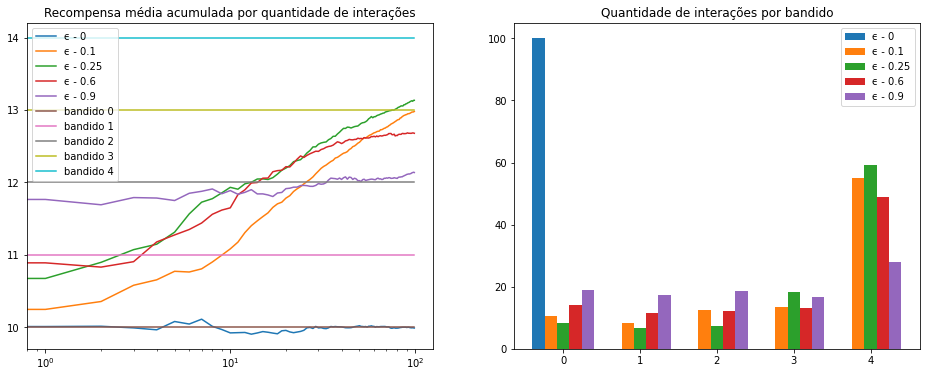

In [ ]:
_, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,6))

plot_rewards(run_avg, ax1, title='Recompensa média acumulada por quantidade de interações')
plot_interactions(run_avg, ax2, title='Quantidade de interações por bandido')

plt.show()

In [ ]:
n_runs = 1

run_1 = main(epsilons, num_explorations=1, n_runs=n_runs)
run_5 = main(epsilons, num_explorations=5, n_runs=n_runs)

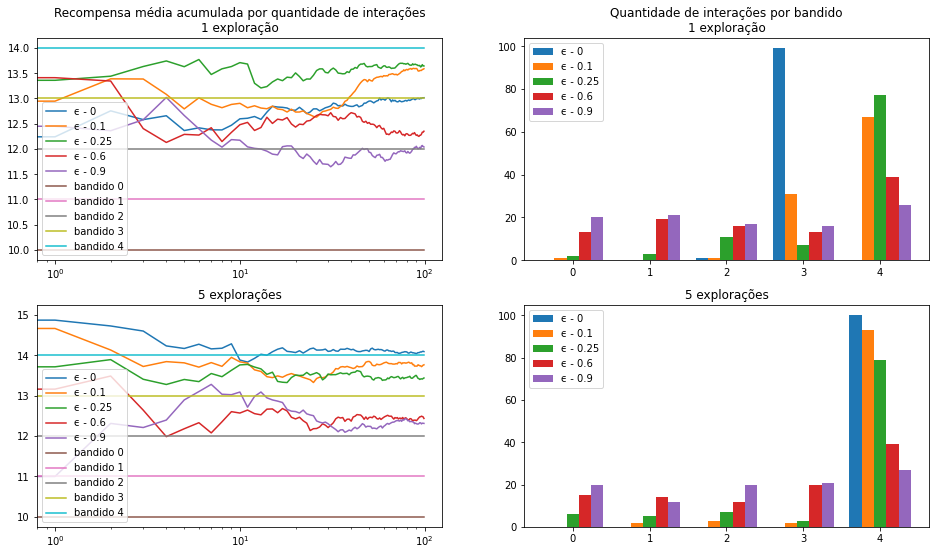

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,9))

plot_rewards(run_1, ax1, title='Recompensa média acumulada por quantidade de interações\n1 exploração')
plot_interactions(run_1, ax2, title='Quantidade de interações por bandido\n1 exploração')
plot_rewards(run_5, ax3, title='5 explorações')
plot_interactions(run_5, ax4, title='5 explorações')

plt.show()

In [ ]:
from scipy.stats import binom

In [ ]:
class BanditBinomial:
  def __init__(self, val):
    self.pmf = binom(n=20, p=0.25).pmf(val)
    self.Q_t = 0
    self.t = 0

  def pull(self):
    if np.random.rand() <= self.pmf :
      return 1
    else:
      return 0

  def update(self, curr_reward):
    self.t += 1
    self.Q_t = self.Q_t + (1.0/self.t) * (curr_reward - self.Q_t)

In [ ]:
def random_policy(bandits):
  index = np.random.choice(len(bandits), 1)[0]
    
  bandit = bandits[index]
  return bandit, index

In [ ]:
def greedy_policy(bandits):
  Q_values = [b.Q_t for b in bandits]

  index = np.argmax(Q_values)
    
  bandit = bandits[index]
  return bandit, index

In [ ]:
def confidence_bound_policy(bandits, t, c=0):
  Q_values = [b.Q_t for b in bandits]
  t_values = [b.t for b in bandits]

  ucb = Q_values + c * np.sqrt(np.log(t) / t_values)

  index = np.argmax(ucb)
    
  bandit = bandits[index]
  return bandit, index

In [ ]:
def random_exploration(bandits):
  b = np.random.choice(bandits)

  interact_with_bandit(b)

In [ ]:
def run_bandits_experiment(bandits_array, num_iterations, policy, c):
  rewards_array = np.empty(num_iterations)
  indexes_array = np.empty(num_iterations)

  for n in np.arange(num_iterations):
    update_rewards = True

    if policy == 'random':
      bandit, index = random_policy(bandits_array)
    elif policy == 'greedy':
      if n <= num_iterations*0.1:
        random_exploration(bandits_array)
        update_rewards = False
      else:
        bandit, index = greedy_policy(bandits_array)
    elif policy == 'ucb':
      bandit, index = confidence_bound_policy(bandits_array, n+1, c=c)

    if update_rewards:
      curr_reward = interact_with_bandit(bandit)
      rewards_array[n] = curr_reward
      indexes_array[n] = index

  return rewards_array, indexes_array

In [ ]:
def main1_2(num_iterations=150, policy='random', c=0, n_runs=1):
  val_array = list(range(20))
  mean_cumulative_reward = np.empty(num_iterations)
  interactions = np.zeros(num_iterations)
  rewards_array = np.zeros(num_iterations)

  for run in range(n_runs):
    bandits_array = list(map(lambda val: BanditBinomial(val), val_array))
    arr, inter = run_bandits_experiment(bandits_array, num_iterations, policy, c)
    rewards_array += arr
    interactions += inter

  mean_cumulative_reward = get_mean_cumulative_reward(rewards_array/n_runs)
  interactions = interactions/n_runs

  return {
      'bandits': bandits_array, 
      'rewards': mean_cumulative_reward,
      'num_iterations': num_iterations,
      'interactions': interactions}

In [ ]:
def plot_rewards1_2(run, ax, 
                    title='Plot das recompensas médias acumuladas',
                    xlabel='Número de iterações',
                    ylabel='Recompensa média acumulada'):
  bandits_array = run['bandits']
  mean_cumulative_reward = run['rewards']
  num_iterations = run['num_iterations']

  legends = []

  ax.plot(mean_cumulative_reward)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)

In [ ]:
num_iterations=150
n_runs=10

random_run = main1_2(num_iterations=num_iterations, policy='random', n_runs=n_runs)
greedy_run = main1_2(num_iterations=num_iterations, policy='greedy', n_runs=n_runs)
ucb_run = main1_2(num_iterations=num_iterations, policy='ucb', c=3, n_runs=n_runs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


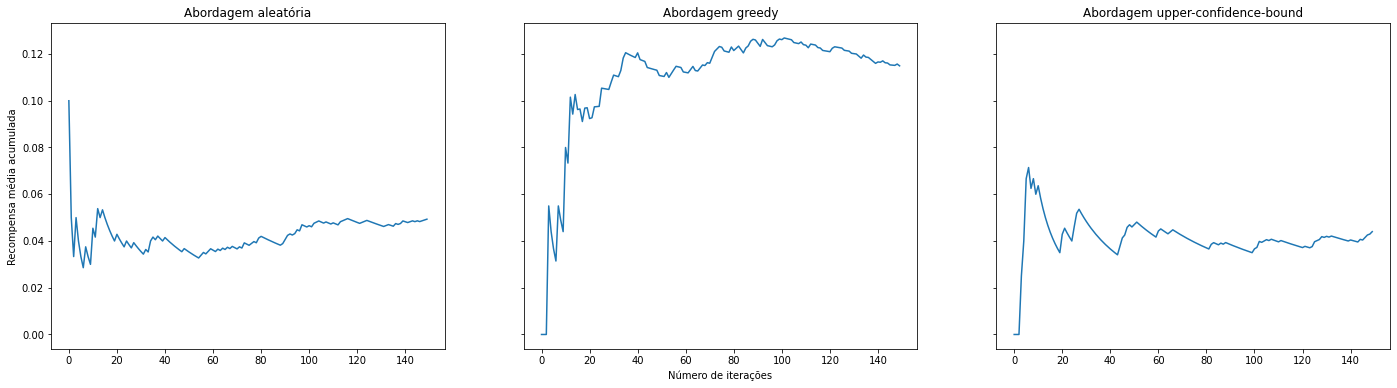

In [ ]:
_, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,6))

plot_rewards1_2(random_run, ax1, title='Abordagem aleatória', xlabel='')
plot_rewards1_2(greedy_run, ax2, title='Abordagem greedy', ylabel='')
plot_rewards1_2(ucb_run, ax3, title='Abordagem upper-confidence-bound', xlabel='', ylabel='')

plt.show()

In [ ]:
num_iterations=150
n_runs=10

run_001 = main1_2(num_iterations=num_iterations, policy='ucb', c=0.01, n_runs=n_runs)
run_05 = main1_2(num_iterations=num_iterations, policy='ucb', c=0.5, n_runs=n_runs)
run_1 = main1_2(num_iterations=num_iterations, policy='ucb', c=1, n_runs=n_runs)
run_3 = main1_2(num_iterations=num_iterations, policy='ucb', c=3, n_runs=n_runs)
run_10 = main1_2(num_iterations=num_iterations, policy='ucb', c=10, n_runs=n_runs)
run_50 = main1_2(num_iterations=num_iterations, policy='ucb', c=50, n_runs=n_runs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


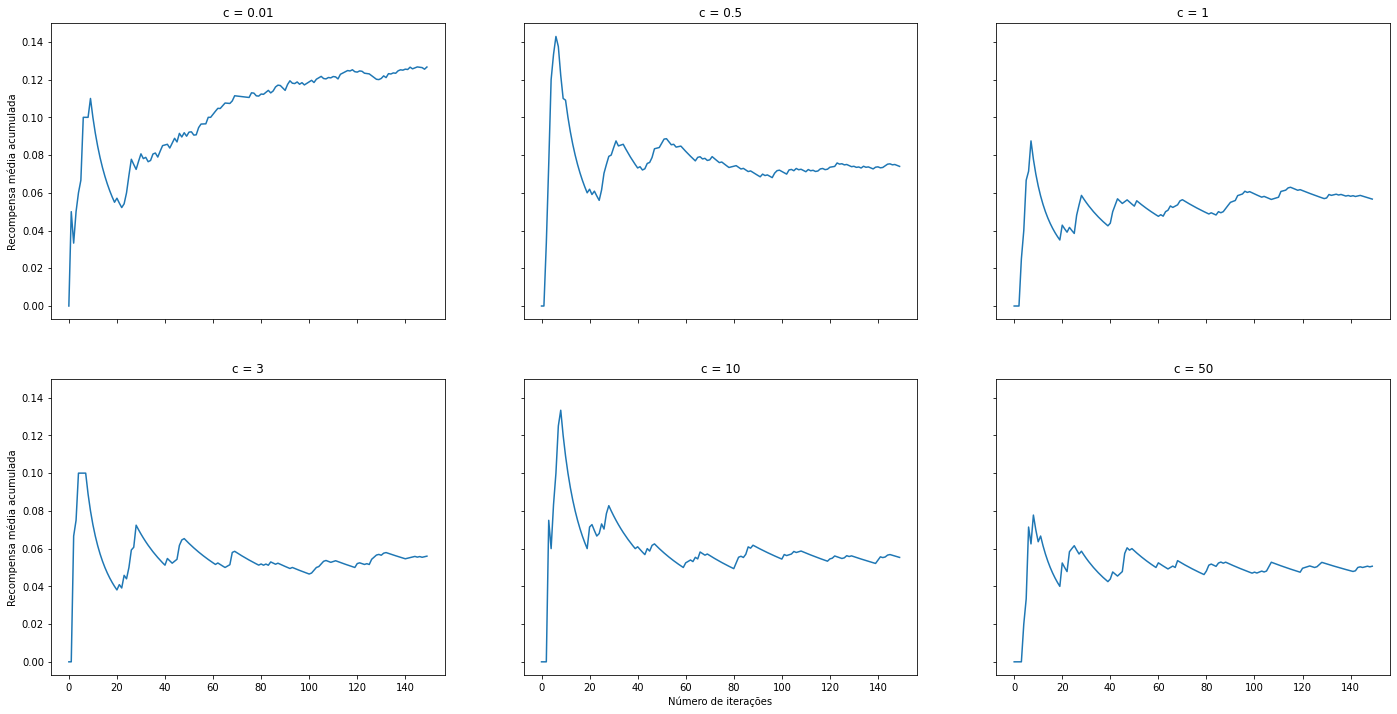

In [ ]:
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(24,12))

plot_rewards1_2(run_001, ax1, title='c = 0.01', xlabel='')
plot_rewards1_2(run_05, ax2, title='c = 0.5', xlabel='', ylabel='')
plot_rewards1_2(run_1, ax3, title='c = 1', xlabel='', ylabel='')
plot_rewards1_2(run_3, ax4, title='c = 3', xlabel='')
plot_rewards1_2(run_10, ax5, title='c = 10', ylabel='')
plot_rewards1_2(run_50, ax6, title='c = 50', xlabel='', ylabel='')

plt.show()

In [ ]:
num_iterations=1500
n_runs=10

run_001 = main1_2(num_iterations=num_iterations, policy='ucb', c=0.01, n_runs=n_runs)
run_05 = main1_2(num_iterations=num_iterations, policy='ucb', c=0.5, n_runs=n_runs)
run_1 = main1_2(num_iterations=num_iterations, policy='ucb', c=1, n_runs=n_runs)
run_3 = main1_2(num_iterations=num_iterations, policy='ucb', c=3, n_runs=n_runs)
run_10 = main1_2(num_iterations=num_iterations, policy='ucb', c=10, n_runs=n_runs)
run_50 = main1_2(num_iterations=num_iterations, policy='ucb', c=50, n_runs=n_runs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


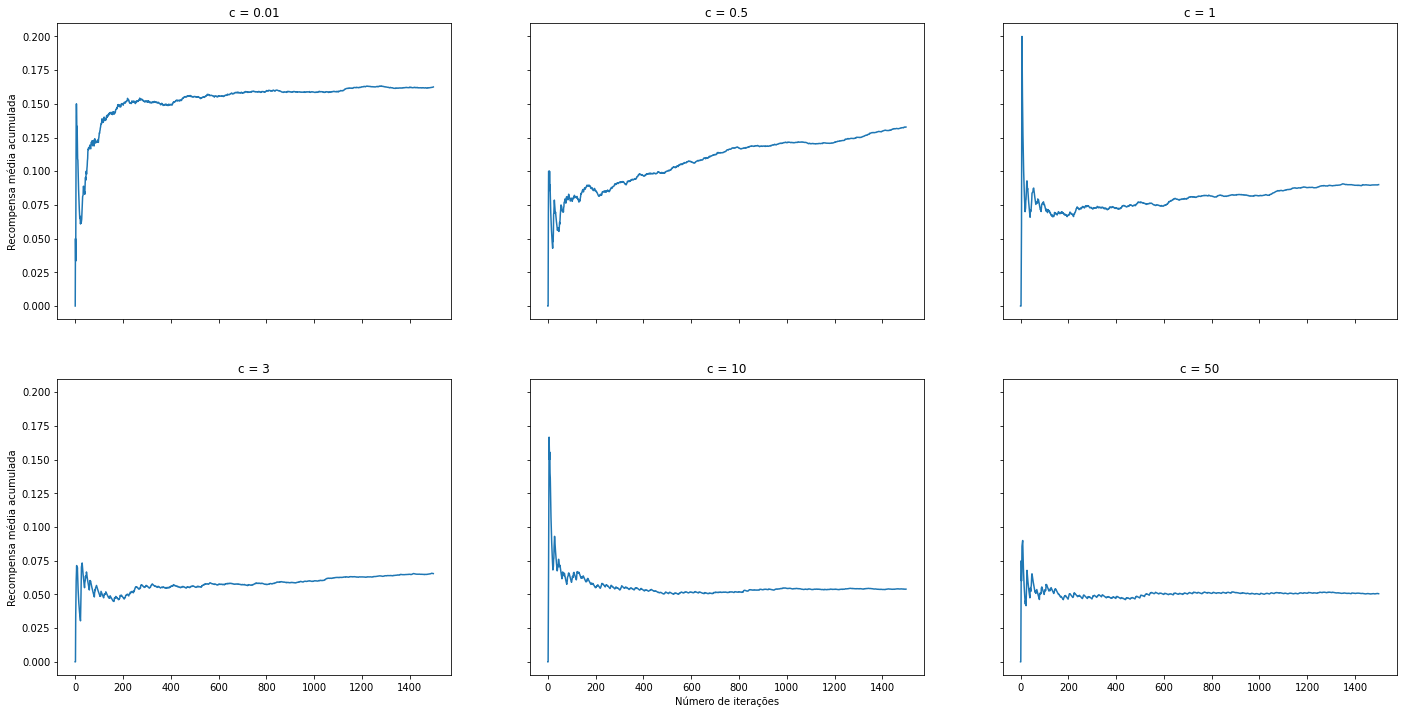

In [ ]:
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(24,12))

plot_rewards1_2(run_001, ax1, title='c = 0.01', xlabel='')
plot_rewards1_2(run_05, ax2, title='c = 0.5', xlabel='', ylabel='')
plot_rewards1_2(run_1, ax3, title='c = 1', xlabel='', ylabel='')
plot_rewards1_2(run_3, ax4, title='c = 3', xlabel='')
plot_rewards1_2(run_10, ax5, title='c = 10', ylabel='')
plot_rewards1_2(run_50, ax6, title='c = 50', xlabel='', ylabel='')

plt.show()

In [ ]:
def variable_confidence_bound_policy(bandits, t, c=0):
  Q_values = [b.Q_t for b in bandits]
  t_values = [b.t for b in bandits]

  ucb = Q_values + c * np.sqrt(np.log(t) / t_values)

  index = np.argmax(ucb)
    
  bandit = bandits[index]
  return bandit, index

In [ ]:
def run_bandits_experiment1_3(bandits_array, num_iterations):
  rewards_array = np.empty(num_iterations)
  indexes_array = np.empty(num_iterations)

  for n in np.arange(num_iterations):
    c = ((num_iterations - n)/num_iterations)*0.5
    bandit, index = variable_confidence_bound_policy(bandits_array, n+1, c=c)

    curr_reward = interact_with_bandit(bandit)
    rewards_array[n] = curr_reward
    indexes_array[n] = index

  return rewards_array, indexes_array

In [ ]:
def main1_3(num_iterations=150, n_runs=1):
  val_array = list(range(20))
  mean_cumulative_reward = np.empty(num_iterations)
  rewards_array = np.zeros(num_iterations)

  for run in range(n_runs):
    bandits_array = list(map(lambda val: BanditBinomial(val), val_array))
    arr, _ = run_bandits_experiment1_3(bandits_array, num_iterations)
    rewards_array += arr
  mean_cumulative_reward = get_mean_cumulative_reward(rewards_array/n_runs)

  return {
      'bandits': bandits_array, 
      'rewards': mean_cumulative_reward,
      'num_iterations': num_iterations}

In [ ]:
num_iterations=150

run= main1_3(num_iterations=num_iterations, n_runs=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


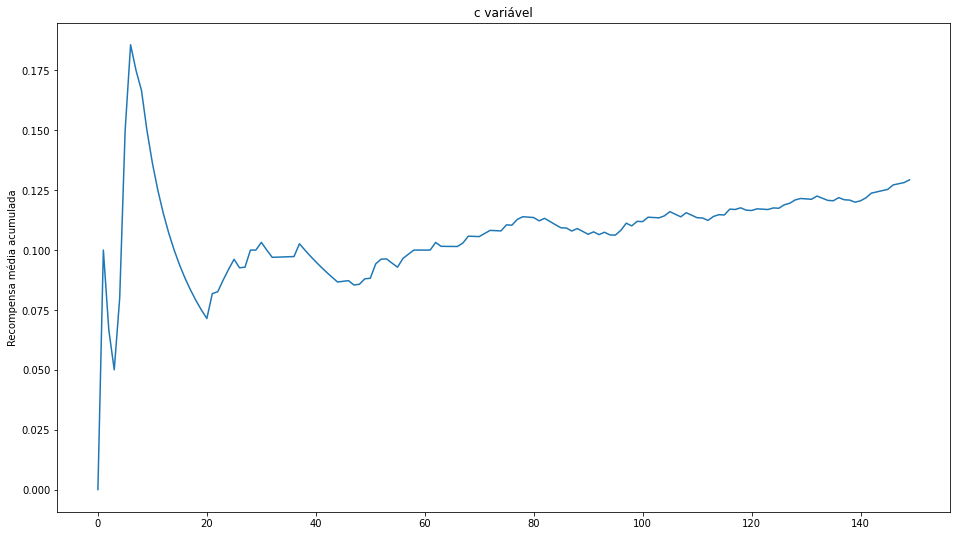

In [ ]:
_, ax = plt.subplots(figsize=(16,9))

plot_rewards1_2(run, ax, title='c variável', xlabel='')

plt.show()

In [ ]:
# CÉLULAS DE CÓDIGO AQUI
import numpy as np

NUM_LINES = 4
NUM_COLS = 4
GAMMA = 1
FINAL_STATES = [[0,0], [NUM_LINES-1, NUM_COLS-1]]
REWARD = -1

num_explorations = 1

direita = [0, 1]
esquerda = [0, -1]
cima = [-1, 0]
baixo = [1, 0]
full_actions = [direita, esquerda, cima, baixo]

policy = np.zeros((NUM_LINES, NUM_COLS), dtype=object)
for i in range(NUM_LINES):
    for j in range(NUM_COLS):
        policy[i,j] = full_actions
        
v_pi = np.zeros((NUM_LINES, NUM_COLS))

In [ ]:
def get_reward(state, action, value_map, prob):
    new_position = list(np.array(state) + np.array(action))

    if -1 in new_position \
          or new_position[0] == NUM_LINES \
          or new_position[1] == NUM_COLS:
        new_position = state

    return prob * (REWARD + GAMMA * value_map[new_position[0], new_position[1]])

In [ ]:
def policy_print(policy):
    lines = policy.shape[0]
    cols = policy.shape[1]
    policy_return = np.zeros((lines, cols), dtype=object)
    
    direita = [0, 1]
    esquerda = [0, -1]
    cima = [-1, 0]
    baixo = [1, 0]
    
    for i in range(lines):
        for j in range(cols):
            if policy[i,j] == None:
                policy_return[i,j] = 'X'
                continue
                
            directions = []
            for direction in policy[i,j]:
                if direction == direita:
                    directions.append('Direita')
                elif direction == esquerda:
                    directions.append('Esquerda')
                elif direction == cima:
                    directions.append('Cima')
                elif direction == baixo:
                    directions.append('Baixo')
                    
            policy_return[i,j] = ' / '.join([str(x) for x in directions])
            
    return policy_return

In [ ]:
iteration = 1
while True:
    ### Evaluation
    for exp in range(num_explorations):
        copyv_pi = np.copy(v_pi)
        
        for i in range(NUM_LINES):
            for j in range(NUM_COLS):
                state = [i,j]

                if state in FINAL_STATES:
                    continue

                actions = policy[i][j]
                rewards = 0
                prob = 1/len(actions)

                for action in actions:
                    rewards += get_reward(state, action, copyv_pi, prob)

                v_pi[i,j] = rewards

    ### Improvement
    old_policy = policy.copy()

    for i in range(NUM_LINES):
        for j in range(NUM_COLS):
            state = [i,j]
            
            if state in FINAL_STATES:
                policy[i,j] = None
                continue

            action_returns = []
            prob = 1/len(full_actions)
            
            for action in full_actions:
                action_returns.append(get_reward(state, action, v_pi, prob))

            new_actions = []
            best_idxs = np.argwhere(action_returns == np.amax(action_returns)).flatten().tolist()
            for idx in best_idxs:
                new_actions.append(full_actions[idx])

            policy[i,j] = new_actions
    
    policy_stable = np.all(old_policy == policy)
    
    if policy_stable:
        print("Política estável na iteração ", iteration - 1)
        break
    else:
        print("-"*30)
        print("Iteração ", iteration)
        print("-"*30)
        print("Matriz de Valor: \n",v_pi,"\n")
        print("Política: \n",policy_print(policy),"\n")
        
    iteration += 1

------------------------------
Iteração  1
------------------------------
Matriz de Valor: 
 [[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]] 

Política: 
 [['X' 'Esquerda' 'Direita / Esquerda / Cima / Baixo'
  'Direita / Esquerda / Cima / Baixo']
 ['Cima' 'Direita / Esquerda / Cima / Baixo'
  'Direita / Esquerda / Cima / Baixo' 'Direita / Esquerda / Cima / Baixo']
 ['Direita / Esquerda / Cima / Baixo' 'Direita / Esquerda / Cima / Baixo'
  'Direita / Esquerda / Cima / Baixo' 'Baixo']
 ['Direita / Esquerda / Cima / Baixo' 'Direita / Esquerda / Cima / Baixo'
  'Direita' 'X']] 

------------------------------
Iteração  2
------------------------------
Matriz de Valor: 
 [[ 0. -1. -2. -2.]
 [-1. -2. -2. -2.]
 [-2. -2. -2. -1.]
 [-2. -2. -1.  0.]] 

Política: 
 [['X' 'Esquerda' 'Esquerda' 'Direita / Esquerda / Cima / Baixo']
 ['Cima' 'Esquerda / Cima' 'Direita / Esquerda / Cima / Baixo' 'Baixo']
 ['Cima' 'Direita / Esquerda / Cima / Baixo' 'Direita / Baixo' 'Baix

In [ ]:
# CÉLULAS DE CÓDIGO AQUI
import numpy as np

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!git clone https://github.com/maximecb/gym-minigrid

Cloning into 'gym-minigrid'...
remote: Enumerating objects: 1767, done.
remote: Total 1767 (delta 0), reused 0 (delta 0), pack-reused 1767
Receiving objects: 100% (1767/1767), 7.10 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (1215/1215), done.


In [ ]:
cd gym-minigrid

/content/gym-minigrid/gym-minigrid


In [ ]:
!pip install -e .

Obtaining file:///content/gym-minigrid/gym-minigrid
  Found existing installation: gym-minigrid 1.0.1
    Can't uninstall 'gym-minigrid'. No files were found to uninstall.
  Running setup.py develop for gym-minigrid


In [ ]:
gamma = 0.7
reward = -1
grid_size = 10
terminal_states = [[grid_size-1, grid_size-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
iterations = 100

In [ ]:
# init
value_map = np.zeros((grid_size, grid_size))
returns = {(i, j):list() for i in range(grid_size) for j in range(grid_size)}
states = [[i, j] for i in range(grid_size) for j in range(grid_size)]

In [ ]:
def generateEpisode():
    index = np.random.choice(len(states[1:-1]))
    init_state = states[index]
    episode = []
    while True:
        if list(init_state) in terminal_states:
            return episode
        index = np.random.choice(len(actions))
        action = actions[index]
        final_state = np.array(init_state) + np.array(action)
        if -1 in list(final_state) or grid_size in list(final_state):
            final_state = init_state
        episode.append([list(init_state), action, reward, list(final_state)])
        init_state = final_state

In [ ]:
for it in range(iterations):
    episode = generateEpisode()
    G = 0

    episode = episode[::-1]
    initial_states_list = [e[0] for e in episode]
    for i, (initial_state, action, reward, final_state) in enumerate(episode):
        G = gamma * G + reward

        is_first_visit = initial_state not in initial_states_list[i+1:]
        if is_first_visit:
            idx = tuple(initial_state)
            returns[idx].append(G)
            new_value = np.average(returns[idx])
            value_map[idx] = new_value

In [ ]:
def get_greedy_action_matrix(value_map):
    grid_shape = value_map.shape
    greedy_policy = np.ndarray(shape=value_map.shape, dtype=object)
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            left = [i, j - 1] if j - 1 >= 0 else None
            right = [i, j + 1] if j + 1 <= grid_shape[1] - 1 else None
            up = [i - 1, j] if i - 1 >= 0 else None
            down = [i + 1, j] if i + 1 <= grid_shape[0] - 1 else None

            dir_dict = {'left': left, 'right': right, 'up': up, 'down': down}
            max_value_function = None
            
            valid_position = np.where(list(dir_dict.values()))[0][0]
            coordinates = list(dir_dict.values())[valid_position]
            max_value_function = value_map[coordinates[0], coordinates[1]]
            greedy_actions = [list(dir_dict.keys())[valid_position]]

            del dir_dict[greedy_actions[0]]

            for dir_key in dir_dict:
                if dir_key == greedy_actions:
                    continue

                if dir_dict[dir_key] is not None:
                    curr_state_value = value_map[dir_dict[dir_key][0], dir_dict[dir_key][1]]
                    if max_value_function < curr_state_value:
                        greedy_actions = [dir_key]
                        max_value_function = curr_state_value
                    elif max_value_function == curr_state_value:
                        greedy_actions.append(dir_key)

            greedy_policy[i, j] = greedy_actions
    return greedy_policy

In [ ]:
print(value_map)
greedy_policy = get_greedy_action_matrix(value_map)
print(greedy_policy)

[[-3.33333333 -3.33333333 -3.33333001 -3.33333101 -3.33333216 -3.33333333
  -3.33333333 -3.33333333 -3.33333333 -3.33333332]
 [-3.33333333 -3.33333333 -3.33332408 -3.33333333 -3.3333322  -3.33333333
  -3.33333314 -3.33333327 -3.33333331 -3.33333331]
 [-3.33333333 -3.33333333 -3.33330674 -3.33333333 -3.33333278 -3.33333333
  -3.33333173 -3.33327707 -3.33329422 -3.33332985]
 [-3.33324852 -3.33328056 -3.33329422 -3.33333333 -3.33333296 -3.33332385
  -3.33333177 -3.33329367 -3.33321819 -3.33328829]
 [-3.33333326 -3.33318123 -3.33311848 -3.33333023 -3.33328126 -3.33328044
  -3.3327253  -3.3315425  -3.3305046  -3.33332553]
 [-3.33333326 -3.33333306 -3.33302567 -3.33332887 -3.33326237 -3.33299701
  -3.33109612 -3.33190935 -3.31553824 -3.3199555 ]
 [-3.33333303 -3.33333185 -3.33289761 -3.3326031  -3.33239762 -3.33076806
  -3.32675357 -3.32739705 -3.31933516 -3.30738125]
 [-3.33333289 -3.33333304 -3.33329555 -3.33301022 -3.3271602  -3.32462001
  -3.32161549 -3.31269275 -3.27245787 -3.17857302]


In [ ]:
import gym
import gym_minigrid
from gym_minigrid.wrappers import *
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import itertools

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                                loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                         </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [ ]:
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
def get_action(desired_direction, observation_direction, action_direction_map):
    if (action_direction_map['right'] == desired_direction
        and action_direction_map['up'] == observation['direction']) \
    or (action_direction_map['left'] == desired_direction
        and action_direction_map['down'] == observation['direction']) \
    or (action_direction_map['down'] == desired_direction
        and action_direction_map['right'] == observation['direction']) \
    or (action_direction_map['up'] == desired_direction
        and action_direction_map['left'] == observation['direction']):
            return 1
            
    return 0

/content/gym-minigrid/gym_minigrid/window.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  self.ax.set_xticks([], [])
/content/gym-minigrid/gym_minigrid/window.py:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  self.ax.set_yticks([], [])


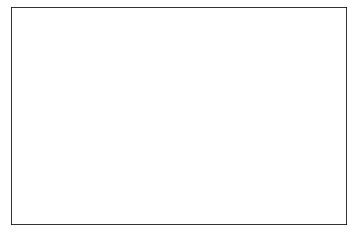

In [ ]:
from gym_minigrid.envs import EmptyEnv

x = np.random.choice(int(grid_size/2)) + 1
y = np.random.choice(int(grid_size/2)) + 1
agent_start_pos=(y,x)

env = wrap_env(EmptyEnv(size=grid_size+2, agent_start_pos=agent_start_pos))
action = None
action_direction_map = {'right': 0, 'down': 1, 'left': 2, 'up': 3}
env.render()
observation = env.reset()
for t in itertools.count(0, 1):
    curr_pos = env.agent_pos
    possible_actions = greedy_policy[curr_pos[1] - 1, curr_pos[0] - 1]
    action = np.random.choice(possible_actions)
    desired_direction = action_direction_map[action]
    while observation['direction'] != desired_direction:
        act = get_action(desired_direction, observation['direction'], action_direction_map)
        observation, _, _, _ = env.step(act)
    observation, reward, done, info = env.step(2)
    if done:
        break
env.close()
show_video()

In [ ]:
# CÉLULAS DE CÓDIGO AQUI
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [ ]:
start = [3, 0]
gamma = 1
alpha = 0.5

In [ ]:
def getTarget(env):
    if env == 'windy':
        return [3, 7]
    elif env == 'cliff':
        return [3, 11]

In [ ]:
def getGridSize(env):
    if env == 'windy':
        return [7,10]
    elif env == 'cliff':
        return [4,12]

In [ ]:
def initQ(env):
    Q = {}
    grid_size = getGridSize(env)
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            Q[(i,j)] = np.zeros(len(actions))
            
    return Q

In [ ]:
def fixPosition(position, env):
    grid_size = getGridSize(env)
    
    position[0] = min(position[0], grid_size[0] - 1)
    position[0] = max(position[0], 0)
    position[1] = min(position[1], grid_size[1] - 1)
    position[1] = max(position[1], 0)
    return position

In [ ]:
def getWind(position, stochastic):
    winds = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    wind = winds[position]
    
    if stochastic:
        prob = np.random.rand()
        if prob <= 1/3:
            wind -= 1
        elif prob <= 2/3:
            wind += 1

    return max(wind, 0)

In [ ]:
def getPositionReward(atual, acao, env, stochastic):
    reward = -1
    grid_size = getGridSize(env)
    
    if env == 'windy':
        wind = getWind(atual[1], stochastic)
        new_position = np.array(atual) + np.array(acao) + np.array([-1, 0]) * wind
        new_position = fixPosition(new_position, env)
        
        return new_position, reward, wind
    elif env == 'cliff':
        new_position = np.array(atual) + np.array(acao)
        new_position = fixPosition(new_position, env)
        
        cliff = np.arange(grid_size[1] - 2) + 1

        if new_position[0] == (grid_size[0] - 1) \
           and new_position[1] in cliff:
            reward = -100
            new_position = np.array(start)
    
        return new_position, reward

In [ ]:
def isTargetState(position, env):
    target = getTarget(env)
    
    if (position == target).all():
        return True
    
    return False

In [ ]:
def getAction(Q, actions, state, epsilon=0.9):
    pos = (state[0], state[1])
    
    if np.random.rand() <= epsilon:
        best_idxs = np.argwhere(Q[pos] == np.amax(Q[pos])).flatten().tolist()
        idx = np.random.choice(best_idxs)
    else:
        idx = np.random.choice(len(actions))
    
    return actions[idx], idx

In [ ]:
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot do comprimento do episódio no tempo
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats['lengths'])
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show()

    # Plot da recompensa do episódio no tempo
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats['rewards']).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show()

    return fig1, fig2

In [ ]:
def train(actions, Q=None, num_iterations=1000, plot=False, algorithm='sarsa', env='windy', stochastic=False):
    stats = {'lengths': [], 'rewards': []}
    
    if Q == None:
        Q = initQ(env)
    
    for i in range(num_iterations):
        state = start
        if algorithm == 'sarsa':
            action, action_index = getAction(Q, actions, state)

        stats['lengths'].append(0)
        stats['rewards'].append(0)

        for it in itertools.count():
            if algorithm == 'qlearning':
                action, action_index = getAction(Q, actions, state)
            
            if env == 'windy':
                next_state, reward, _ = getPositionReward(state, action, env, stochastic)
            elif env == 'cliff':
                next_state, reward = getPositionReward(state, action, env, stochastic)

            if algorithm == 'sarsa':
                next_action, next_action_index = getAction(Q, actions, next_state)
            elif algorithm == 'qlearning': 
                next_action, next_action_index = getAction(Q, actions, next_state, epsilon=1)

            td_target = reward + gamma * Q[(next_state[0], next_state[1])][next_action_index]
            td_delta = td_target - Q[(state[0], state[1])][action_index]
            Q[(state[0], state[1])][action_index] += alpha * td_delta

            stats['lengths'][i] = it
            stats['rewards'][i] += reward

            state = next_state
            
            if algorithm == 'sarsa':
                action = next_action
                action_index = next_action_index

            if isTargetState(state, env):
                break
                
    if plot:
        plot_episode_stats(stats)
        
    return Q

In [ ]:
def outWriteDefault(i, j, state, env):
    posicao = [i,j]
    
    if (posicao == state).all():
        sys.stdout.write(' X ')
    elif isTargetState(np.array(posicao), env):
        sys.stdout.write(' T ')
    else:
        sys.stdout.write(' . ')
    

def outWrite(i, j, state, env, grid_size, cliff):
    if env == 'windy':
        if i < grid_size[0]:
            outWriteDefault(i, j, state, env)
        else:
            sys.stdout.write(f' {str(getWind(j, False))} ')
            if j == (grid_size[1] - 1):
                sys.stdout.write(' Ventos médios')
    elif env == 'cliff':
        if i == (grid_size[0] - 1) and j in cliff:
            sys.stdout.write(' ~ ')
        else:
            outWriteDefault(i, j, state, env)
    

def plotIterations(Q, actions, actions_dict, env, stochastic=False, max_iter=50):
    state = np.array(start)
    done = False
    it = 0
    grid_size = getGridSize(env)
    cliff = np.arange(grid_size[1] - 2) + 1
    reward_total = 0
    
    if env == 'windy':
        y_range = grid_size[0] + 1
    elif env == 'cliff':
        y_range = grid_size[0]
        
    while not done and it < max_iter:
        print('Iteração ', it)
        for i in range(y_range):
            for j in range(grid_size[1]):
                outWrite(i, j, state, env, grid_size, cliff)
            sys.stdout.write('\n')

        done = isTargetState(state, env)
        
        if it > 0:
            print('Ação: ', actions_dict[tuple(acao)])
            
            if env == 'windy':
                print('Vento: ', vento)
            elif env == 'cliff' and reward == -100:
                print('Caiu no precipício!')
                
        if not done:
            acao, _ = getAction(Q, actions, state, epsilon=1)
            
            if env == 'windy':
                state, reward, vento = getPositionReward(state, acao, env, stochastic)
            if env == 'cliff':
                state, reward = getPositionReward(state, acao, env, stochastic)
                
            reward_total += reward

            it += 1
            print()
        
    print('\nRecompensa obtida: ', reward_total)

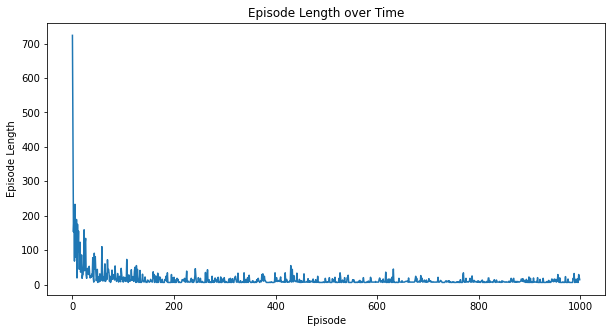

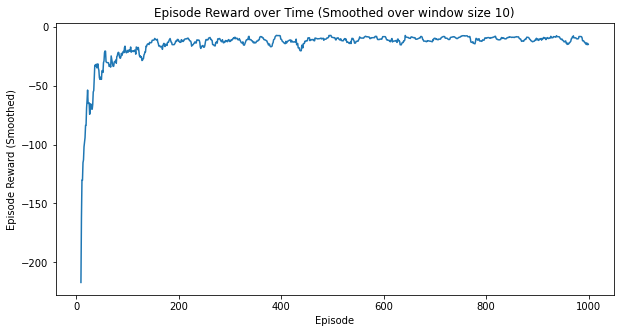

In [ ]:
actions = [[-1, 0], [1, 0], [0, 1], [0, -1], [-1, -1], [-1, 1], [1, 1], [1, -1]]
actions_dict = {(-1, 0): 'cima',
                (1, 0): 'baixo',
                (0, 1): 'direita',
                (0, -1): 'esquerda',
                (-1, -1): 'cima-esquerda',
                (-1, 1): 'cima-direita',
                (1, 1): 'baixo-direita',
                (1, -1): 'baixo-esquerda'}

Q = train(actions, plot=True, algorithm='sarsa', env='windy')

In [ ]:
plotIterations(Q, actions, actions_dict, 'windy')

Iteração  0
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios

Iteração  1
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  X  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  cima-direita
Vento:  0

Iteração  2
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  X  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  baixo-direita
Vento:  0

Iteração  3
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  . 

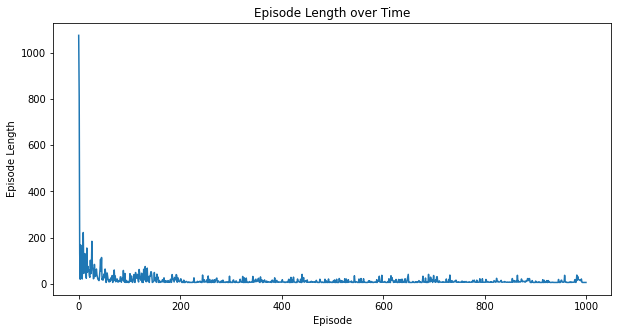

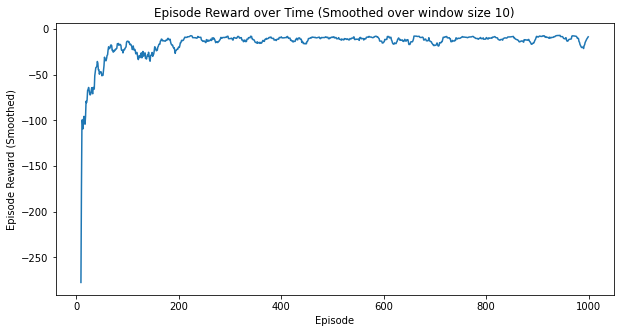

In [ ]:
actions = [[0, 0], [-1, 0], [1, 0], [0, 1], [0, -1], [-1, -1], [-1, 1], [1, 1], [1, -1]]
actions_dict = {(0, 0): 'para', 
                (-1, 0): 'cima',
                (1, 0): 'baixo',
                (0, 1): 'direita',
                (0, -1): 'esquerda',
                (-1, -1): 'cima-esquerda',
                (-1, 1): 'cima-direita',
                (1, 1): 'baixo-direita',
                (1, -1): 'baixo-esquerda'}

Q = train(actions, plot=True, algorithm='sarsa', env='windy')

In [ ]:
plotIterations(Q, actions, actions_dict, 'windy')

Iteração  0
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios

Iteração  1
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  T  .  . 
 .  X  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  baixo-direita
Vento:  0

Iteração  2
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  X  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  baixo-direita
Vento:  0

Iteração  3
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .

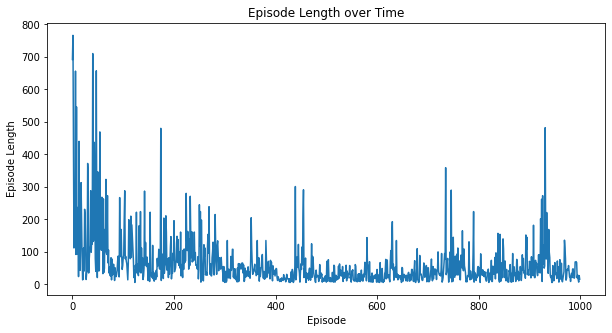

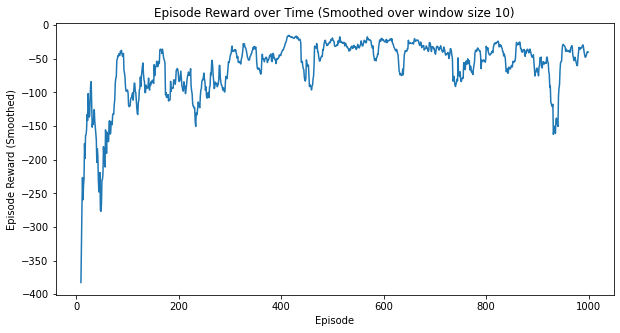

In [ ]:
# CÉLULAS DE CÓDIGO AQUI
actions = [[-1, 0], [1, 0], [0, 1], [0, -1], [-1, -1], [-1, 1], [1, 1], [1, -1]]
actions_dict = {(-1, 0): 'cima',
                (1, 0): 'baixo',
                (0, 1): 'direita',
                (0, -1): 'esquerda',
                (-1, -1): 'cima-esquerda',
                (-1, 1): 'cima-direita',
                (1, 1): 'baixo-direita',
                (1, -1): 'baixo-esquerda'}

Q = train(actions, plot=True, algorithm='sarsa', env='windy', stochastic=True)

In [ ]:
plotIterations(Q, actions, actions_dict, 'windy')

Iteração  0
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios

Iteração  1
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  T  .  . 
 .  X  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  baixo-direita
Vento:  0

Iteração  2
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  T  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  X  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 0  0  0  1  1  1  2  2  1  0  Ventos médios
Ação:  baixo-direita
Vento:  0

Iteração  3
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .

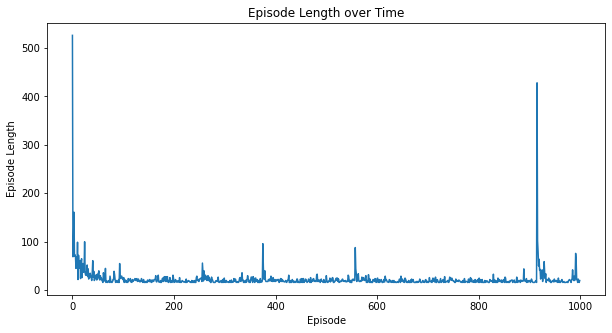

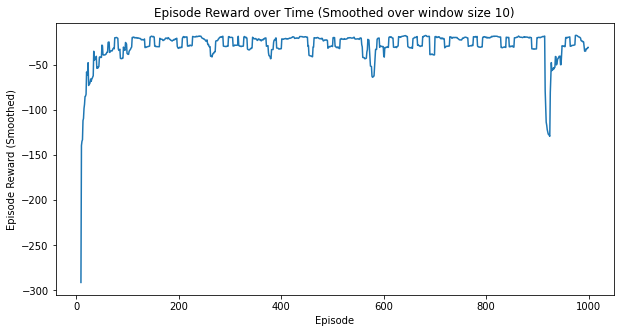

In [ ]:
# CÉLULAS DE CÓDIGO AQUI
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
actions_dict = {(-1, 0): 'cima',
                (1, 0): 'baixo',
                (0, 1): 'direita',
                (0, -1): 'esquerda'}

Q = train(actions, plot=True, algorithm='sarsa', env='cliff')

In [ ]:
plotIterations(Q, actions, actions_dict, 'cliff')

Iteração  0
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 X  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 

Iteração  1
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  cima

Iteração  2
 .  .  .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  cima

Iteração  3
 X  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  cima

Iteração  4
 .  X  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  direita

Iteração  5
 .  .  X  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~ 

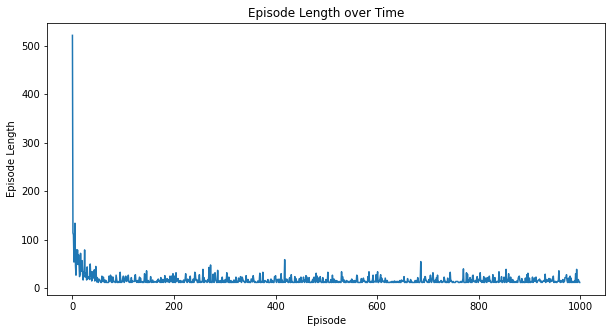

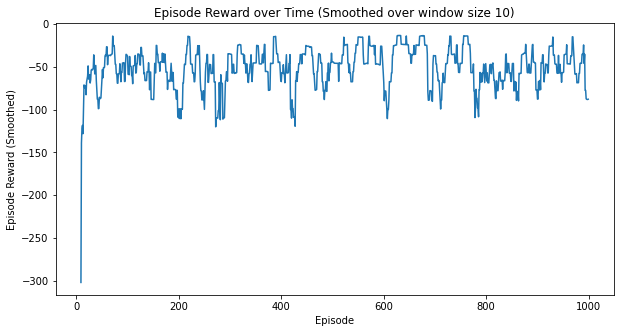

In [ ]:
Q = train(actions, plot=True, algorithm='qlearning', env='cliff')

In [ ]:
plotIterations(Q, actions, actions_dict, 'cliff')

Iteração  0
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 X  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 

Iteração  1
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  cima

Iteração  2
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  X  .  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  direita

Iteração  3
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  X  .  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  direita

Iteração  4
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  X  .  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  T 
Ação:  direita

Iteração  5
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  X  .  .  .  .  .  .  . 
 .  ~  ~  ~  ~ 